# Preparation of Milestone 2

Today we will start to prepare the second milestone. The goals of this milestone are

- Implement an image classification pipeline
    - Implement a Pytorch classification dataset
    - Implement at least two custom augmentations (do not just import one from Torchvision or albumentations)
    - Implement a training and validation loop
    - Optimize your model
    - Evaluate the performance of your model with the F1 score on the test set

# Pytorch Classification Dataset 

To train neural networks in pytorch with custom datasets, custom dataset classes are needed. Today we will work on a dataset for the term project. A general introduction to custom datasets can be found [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).



Your dataset must have several properties that are specific to the task:

1. Since you only have a small number of images, you will need to use image augmentation. Image augmentation is always applied on the fly. **Never apply image augmentation to images and save the augmented versions to disk for sampling!** Normally, you can use the image augmentation implemented in albumentations or torchvision. **For this project, you will need to implement two augmentations yourself**. I would suggest implementing an augmentation that applies a Gaussian blur to the image and a function that applies a color jitter to the image. Implement the augmentations in a way that they can be **composed** with other TorchVision transformations.

2. Apply minority class oversampling and majority class undersampling for better generalization. You can either implement an initialization function in your dataset where you first sample the coordinates for this epoch, or sample the coordinates on the fly in the __getitem__ method.

3. Your dataset class will inherit from torch.utils.data.Dataset. But you must override the **__len__** and **__getitem__** functions.

In [1]:

import numpy as np



def apply_gaussian_blur(image, kernel_size=(5, 5), sigma=1.0):
    """Applies Gaussian blur to a NumPy image array."""
    if len(image.shape) == 3:
        # If image has multiple channels, select a single channel
        image = image[..., 0]  # Assuming we select the first channel
    elif len(image.shape) != 2: # if not raise error.
        raise ValueError("Input image must be a 2-D or 3-D array")
    
    # Define the Gaussian kernel
    ax = np.linspace(-(kernel_size[0] - 1) / 2., (kernel_size[0] - 1) / 2., kernel_size[0])
    ay = np.linspace(-(kernel_size[1] - 1) / 2., (kernel_size[1] - 1) / 2., kernel_size[1])
    xx, yy = np.meshgrid(ax, ay) # create 2d dimensinal grid.
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma)) #calculate the gaussian kernel.
    kernel /= np.sum(kernel) # normalize the kernel.
    
    # Apply the Gaussian kernel to the image using conv. 
    blurred_image = np.zeros_like(image, dtype=np.float64) # create a new image with the same size as the input image.
    padded_image = np.pad(image, ((kernel_size[0]//2, kernel_size[0]//2), (kernel_size[1]//2, kernel_size[1]//2)), mode='constant')
    # pad the image with zeros.
    for i in range(blurred_image.shape[0]): # loop over the image.
        for j in range(blurred_image.shape[1]): 
            patch = padded_image[i:i+kernel_size[0], j:j+kernel_size[1]] # get the patch of the image.
            blurred_image[i, j] = np.sum(patch * kernel) # apply the kernel to the patch.
    
    return blurred_image.astype(np.uint8) 




def apply_color_jitter(image, brightness_factor=1.2, contrast_factor=1.2, saturation_factor=1.2):
    """Applies color jitter to a NumPy image array."""
    image = image * brightness_factor # adjust the brightness. then clip.
    image = np.clip(image, 0, 255)  
    mean = np.mean(image, axis=(0, 1), keepdims=True) # calculate the mean of the image.
    image = (image - mean) * contrast_factor + mean # adjust the contrast by substract the mean. 
    return np.clip(image, 0, 255) # clip the image.




In [2]:
import os
import pandas as pd
from torchvision.transforms.functional import crop, resize, to_tensor
from torch.utils.data import Dataset, DataLoader
from numpy.random import choice
from PIL import Image
import numpy as np
import torch

class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, resize_shape=(64, 64)):
        self.img_labels = pd.read_pickle(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resize_shape = resize_shape

    def __len__(self):
        return len(self.img_labels)
     
    # sample from dataset with index idx.
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) # get the image path.
        image = Image.open(img_path).convert("RGB")  # Ensure image is RGB
        image = np.array(image) # convert the image to numpy array.
        
        # # If the image has only one channel, repeat it to create three channels
        # if image.ndim == 2:
        #     image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        
        # Crop and resize
        max_x, max_y, min_x, min_y = self.img_labels.iloc[idx, [1, 2, 3, 4]]
        image = image[min_y:max_y, min_x:max_x]
        image = np.array(Image.fromarray(image).resize(self.resize_shape)) # resize the image to match the resize_shape.
        
        # Convert to tensor
        image = to_tensor(image.astype(np.uint8)) # convert the image to tensor so that it can be used in pytorch.

        label = self.img_labels.iloc[idx, 5] # get the label of the image.
        #apply transforms to the image.
        if self.transform: 
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

# Example usage:
annotations_file = 'data/AgNORs/annotation_frame.p'
img_dir = 'data/AgNORs/'
dataset = CustomDataset(annotations_file, img_dir, resize_shape=(64, 64))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

for images, labels in dataloader:
    print(images.shape, labels)
    break


torch.Size([64, 3, 64, 64]) tensor([2, 0, 0, 2, 1, 4, 2, 0, 0, 1, 4, 4, 3, 2, 2, 2, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 2, 0, 1, 1, 2, 0, 1, 2, 4, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 4,
        0, 1, 1, 2, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0])


# Training/Validation/Test Split

After you have successfully created your dataset, you need to define a training, validation, and test split of the data. Split the images at the image level! Splits must not overlap!

1. Split the data.
2. Initialize a dataset for each split and pass it to a Pytorch dataloader.

In [3]:
from sklearn.model_selection import train_test_split
import torch



# Split indices of the dataset
indices = list(range(len(dataset)))
train_indices, remaining_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(remaining_indices, test_size=0.5, random_state=42)


# torch.utils.data.Subset creates a subset of the original dataset at the specified indices
# Define datasets using the split indices
train_data = torch.utils.data.Subset(dataset, train_indices)
val_data = torch.utils.data.Subset(dataset, val_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

# Create DataLoader instances for training, validation, and testing datasets.
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


# Initliazie a classification model from pytorch.

For classification we will use a pre-trained model from pytorch. I would suggest an efficientnet_b0. Since we do not have too much training data and to mitigate overfitting, we will use ImageNet weights and only train the last layer. We will also freeze most of the network since we do not have much data and to save training time.

1. Load the model from torchvision (see[https://pytorch.org/vision/stable/models.html]).
2. Load the respective weights.
3. Freeze all but the last layer.
4. If you have a gpu available, bring your model to the gpu.

In [5]:

import torch
import torchvision.models as models
import torch.nn as nn


#Load the pre-trained model
model = models.efficientnet_b0(pretrained=True)

#Freeze all but the last layer (optional)
for name, param in model.named_parameters():
    if "classifier" not in name:  # Exclude the final classifier layers
        param.requires_grad = False # freezeeee

# Step 3: Replace the final fully connected layer with a new one
num_classes = 12  # Number of classes for output
model.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=num_classes)
)


# Step 4: Move the model to GPU if available for macbook
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
# device =torch.device('cpu')
model.to(device)



/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# Optimization Loop

a) The next step is the actual model optimization. But before we implement the training and validation loops, we need to initialize a loss function and an optimizer. We can use Adam as the optimizer and Cross Entropy Loss as the loss function from pytorch. We also need to set a learning rate for the model optimization.

1. Initialize a Loss Function
2. Initializing an Optimizer and Setting a Learning Rate


In [6]:

#step 1 : Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Step 2: Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

b) Now, we will implement an optimization loop. First we implement the training phase. Implement a function (**train_one_epoch**) which performs the follwing steps.:

1. Define a variable running_loss in which you can store the change in loss during training. Since we will later chain the function with a validation function, bring the model to training mode if needed.
2. Iterate over your train dataloader, in each epoch you must:
    1. Transfer the tensors with the images and labels to the GPU or CPU, depending on the device on which your model is located.
    2. Delete the old gradients in the optimizer.
    3. Perform the actual forward pass, i.e. pass the images to the model and calculate the predictions (model(imgs))
    4. Calculate the loss
    5. Backpropagate the loss (loss.backward())
    6. Perform the optimization step (optimizer.stepp())
    7. Add the loss of the current batch to your running_loss
    8. Print the loss every x batches, also return the average loss of the epoch

**Tip:** use **[tqdm.notebook.tqdm](https://tqdm.github.io/docs/notebook/)** to visualize the progress during the epoch.

In [7]:
import torch
from tqdm.notebook import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device, print_freq=100):
    # to store the loss cumulative way.
    running_loss = 0.0
    
    # the model in training mode
    model.train()
    
    # Iterate over the train dataloader
    for i, (images, labels) in enumerate(tqdm(dataloader, desc="Training Batches", leave=False)):
        # Transfer the tensors to the gpu
        images = images.to(device)
        labels = labels.to(device)
        
        # Delete the old gradients
        optimizer.zero_grad()
        
        # Perform the forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backpropagate the loss
        loss.backward()
        
        # Perform the optimization step
        optimizer.step()
        
        # Add the loss of the current batch to running_loss
        running_loss += loss.item()
        
        # # Print the loss every print_freq batches
        # if (i + 1) % print_freq == 0:
        #     avg_loss = running_loss / print_freq
        #     print(f"Batch: [{i+1}/{len(dataloader)}], Loss: {avg_loss:.4f}")
        #     running_loss = 0.0  # Reset running_loss for the next print_freq batches
    
    # Calculate the average loss of the epoch
    avg_loss = running_loss / len(dataloader)
    
    return avg_loss

# run the training loop
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, print_freq=50)
    print(f"Epoch: {epoch+1}, Loss: {train_loss:.4f}")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.4417


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 2, Loss: 1.3123


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 3, Loss: 1.2813


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 4, Loss: 1.2642


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 5, Loss: 1.2534


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 6, Loss: 1.2447


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 7, Loss: 1.2362


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 8, Loss: 1.2336


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 9, Loss: 1.2350


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.2247


c) We also need a validation loop, which is called after a training loop to determine the training progress on the validation data. Implement this in a function (**validate_one_epoch**). This loop looks very similar to the training loop, but we can skip the backpropagation here. Also, use a metric from Torchmetrics to measure the performance of your models. The validation function should also return the loss or the metric so you can use it to select the best model during training.

1. Turn off gradient storage. Put your model in evaluation mode. Since there is no backpropagation in the validation, we do not need it and can save a lot of memory.
2. As with the training loop, iterate over the validation data loader and perform a forward pass in each epoch.
3. Compute a loss in each epoch, but not backpropagated
4. Store and output the loss and return the average loss of the epoch
5. Update your metric with the predictions and labels of each batch
6. Calculate your metric after the last batch.


In [8]:
from torchmetrics import Accuracy
import torch.nn.functional as F

def validate_one_epoch(model, dataloader, criterion, device, num_classes, num_labels):
    # to store the change in loss during validation
    running_loss = 0.0
    
    # to measure the performance of the model
    accuracy = Accuracy(num_classes=num_classes, num_labels=num_labels, task='MULTILABEL').to(device)
    
    # put the model in evaluation mode.
    model.eval()
    
    # Iterate over the validation dataloader
    for images, labels in tqdm(dataloader, desc="Validation Batches", leave=False):
        # Transfer the tensors to the GPU or CPU
        images = images.to(device)
        labels = labels.to(device)
        
        # Convert labels to one-hot encoded format
        labels_one_hot = F.one_hot(labels, num_classes=num_classes).to(torch.float32).to(device)
        
        # Perform the forward pass
        outputs = model(images)
        
        # Calculate the loss (no backpropagation)
        loss = criterion(outputs, labels_one_hot)
        
        # Add the loss of the current batch to running_loss
        running_loss += loss.item()
        
        # Update the metric with the predictions and one-hot encoded labels of each batch
        accuracy.update(outputs.sigmoid(), labels_one_hot)
    
    # Calculate the average loss of the epoch
    avg_loss = running_loss / len(dataloader)
    
    # Calculate the accuracy after the last batch
    acc = accuracy.compute()
    
    return avg_loss, acc

# # let's run the validation loop to check.

val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, num_classes=12, num_labels=12)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")






Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Validation Loss: 1.3261, Validation Accuracy: 0.8346


d) Combine training and validation in an optimization loop. This loop is run **n_epochs** times. In each iteration, first call your training function and then your validation function. In each epoch, check to see if your model has improved, and if so, save the model. Do not save a new checkpoint in each epoch, as this will consume too much memory. Save the losses of the training and validation functions over the epochs to plot them at the end of your training. If you do not have a GPU available, you do not need to train your model to convergence. Just train a few steps.

Epoch 1/5


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Model saved.
Train Loss: 1.2238 | Validation Loss: 1.3213 | Validation Accuracy: 0.8339
Epoch 2/5


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.2154 | Validation Loss: 1.3278 | Validation Accuracy: 0.8424
Epoch 3/5


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.2142 | Validation Loss: 1.3491 | Validation Accuracy: 0.8395
Epoch 4/5


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.2153 | Validation Loss: 1.3592 | Validation Accuracy: 0.8383
Epoch 5/5


Training Batches:   0%|          | 0/249 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 1.2094 | Validation Loss: 1.3584 | Validation Accuracy: 0.8397


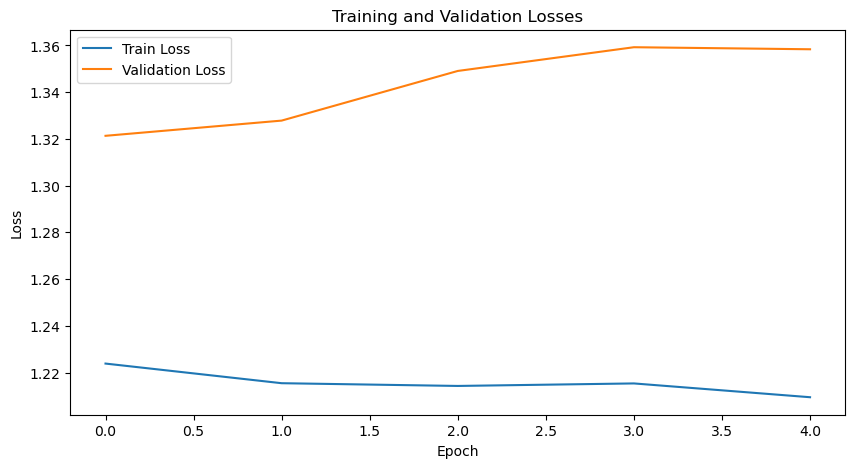

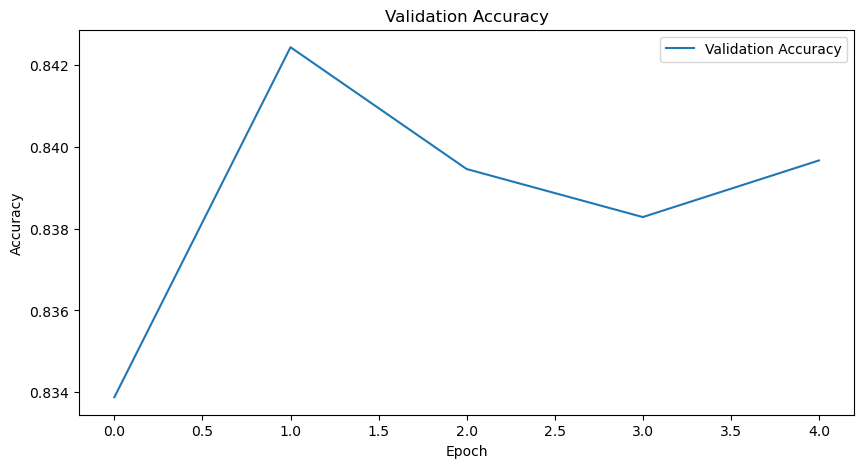

In [9]:
import torch
import matplotlib.pyplot as plt

def optimization_loop(model, train_loader, val_loader, criterion, optimizer, device, n_epochs, model_path, num_classes, num_labels):
    train_losses = []  # Store training losses over epochs
    val_losses = []    # Store validation losses over epochs
    val_accuracies = []  # Store validation accuracies over epochs
    best_val_loss = float('inf')  # Initialize best validation loss
    
    # Loop over the specified number of epochs
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        
        # Training phase
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # Validation phase
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, num_classes, num_labels)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Check if model has improved and save the model if it has
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print("Model saved.")
        
        print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    

    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()
    
    # Convert validation accuracies from tensors to numpy arrays before plotting
    val_accuracies_np = [acc.cpu().numpy() for acc in val_accuracies]
    
    # Plot the validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies_np, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

# Define the number of epochs
n_epochs = 5

# Define the path to save the best model
model_path = 'best_model.pth'

# Start the optimization loop
optimization_loop(model, train_loader, val_loader, criterion, optimizer, device, n_epochs, model_path, num_classes=12, num_labels=12)


# Model testing

Once the optimization is complete, you can test your model on the test data. This means that you apply your model to the images in your dataset. To do this, iterate over all instances in your test data set.

1. Initialize the best performing model.
2. Initialize the F1 score metric from TorchVision.
3. Iterate over all instances in the test dataset and update your metric after each batch.
4. Compute the final metric.

In [10]:
import torch
from torchmetrics import F1Score
from tqdm.notebook import tqdm

def test_model(model, test_loader, device, model_path):
    # Load the best performing model
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Initialize F1 score metric and move it to the device
    f1 = F1Score(num_classes=12, average='macro', task='multiclass').to(device)

    # Iterate over all instances in the test dataset and update F1 score after each batch
    for images, labels in tqdm(test_loader, desc="Test Batches", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        # Perform forward pass
        outputs = model(images)

        # Compute F1 score
        f1.update(outputs.argmax(dim=1), labels)

    # Compute the final F1 score
    final_f1_score = f1.compute()
    
    return final_f1_score

# Test the model
final_f1_score = test_model(model, test_loader, device, model_path)
print(f"Final F1 Score on Test Data: {final_f1_score:.4f}")


Test Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Final F1 Score on Test Data: 0.1501
